In [11]:
import os, sys
sys.path.append(os.path.abspath('../utils'))
import pandas as pd
import matplotlib.pyplot as plt  
from sklearn.linear_model import LogisticRegression
import dca_fs_tools as dcat
import dca_fs as dcafs

import pickle

# Benchmarking pytorch LR implementations with cross-entropy and mean-net-benefit-maximizing loss functions

### Introduction

Later, in subsequent examples, we will demonstrate different approaches to feature selection based on model net benefit. One of these approaches is based on logistic regression with a modified loss function and test-harm-weighted LASSO penalization. Here we describe the implementation of the modified loss function and benchmark it against scikit learn logistic regression model.

The standard loss function used in logistic regression is the cross-entropy:

\begin{equation}
\left\{ ylog(p) +\left(1-y)log(1-p)\right) \right\}
\tag{1}
\end{equation}

As described in [the README file](../README.md), we propose an alternative loss function which maximizes mean net benefit:

\begin{equation}
-\left\{ yp +\left(1-y) (p+log(1-p)\right) \right\} 
\tag{2}
\end{equation}

We use gradient descent optimization and pytorch to fit models with the above loss functions. Some details of the implementation are included below.

In this notebook we use the logistic regression model of scikit learn as a benchmark to which we compare our implementation of logistic regression with either of the above two loss functions.

We fit the following models:

* scikit learn's logistic regression
* our pytorch implementation of logistic regression with cross-entropy loss
* our pytorch implementation of logistic regression with mean-net-benefit maximization loss.

These models are fit on the "well specified LR" synthetic data set described in [00_synthetic_data_description.ipynb](./00_synthetic_data_description.ipynb).

We will see that each of these three models give the same output when the logistic regression is well specified.

### Implementation

We use stochastic gradient descent implemented in pytorch to minimize the above loss functions and fit parameters to synthetic data. The model is structured in analogy to a neural network with a linear layer of one node per independent variable. The most straightforward approach would then be to apply the sigmoid function and apply the cros-entropy loss but it turns out to be more numerically stable to not apply the sigmoid function and apply a loss function that incorporates both the sigmoid and cross-entropy loss. In the case of the cross-entropy loss this is acheived with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html). 

In the case of the mean-net-benefit-maximizing loss function we implement with the class called "mnbLoss" in the dca_fs module. This class combines the mean-net-benefit maximizing loss in equation (2) with the sigmoid function (such that the log-odds is modeled as a linear function of the independent variables). The linear layer of the model outputs $p$ to which we apply the sigmoid function:

\begin{equation}
\sigma(x) = \frac{1}{1-e^{-x}}
\end{equation}

Such that the loss function becomes:

\begin{equation}
-\left\{ y\sigma(p) +\left(1-y) (\sigma(p)+log(1-\sigma(p))\right) \right\} 
\end{equation}

Which simplifies to:

\begin{equation}
(1-y)(p+A)-\sigma(p)
\end{equation}

Where,

\begin{equation}
A = log(1+e^{-p})
\end{equation}

This is more numerically stable than diretly applying the loss function after applying the sigmoid function.

## Logistic regression benchmark

In order to compare to standard logistic regression we employ sklearn's LR:

In [12]:
logreg = LogisticRegression(C=10**18)

We generate sythetic data for whcih lagistic regression is well-specified (as described in [00_synthetic_data_description.ipynb](./00_synthetic_data_description.ipynb)) with specified true model parameters (note that the dataset is plit 80/20 into train and test sets.)

In [13]:
n_sample = 100000
true_params = [1.7, 0.8, -0.4]

df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    dcat.make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = true_params, true_bias=0.0, heteros=0.)

Fit the baseline sklearn LR:

In [14]:
logreg.fit(df_train[ind_var_names], df_train["y"])

LogisticRegression(C=1000000000000000000)

Fit our implementation of logistic regression with cross-entropy loss and also mean-net-benefit mizimising loss: 

In [15]:
my_log_loss_model = dcafs.lr_train(df_train, n_epochs=10000, learn_rate=  1.0, loss_fun = 'log')
my_mnb_loss_model = dcafs.lr_train(df_train, n_epochs=10000, learn_rate=  1.0, loss_fun = 'mnb')

Make predictions from the three models on the test set.

In [16]:
# Make predictions
sklearn_pred = logreg.predict_proba(df_test.drop("y", axis = 1))
my_log_loss_pred = dcat.make_net_prediction(my_log_loss_model["net"], df_test)
my_mnb_loss_pred = dcat.make_net_prediction(my_mnb_loss_model["net"], df_test)

# Collect the results
combined_predictions = pd.concat([
    pd.DataFrame(sklearn_pred[:,1], columns = ["sklearn"]),
    pd.DataFrame(my_log_loss_pred, columns = ["log"]),
    pd.DataFrame(my_mnb_loss_pred, columns = ["mnb"])],
    axis = 1
)

#Claculate the difference between our implementations and scikit learn:
combined_predictions["delta_skl_log"] = combined_predictions["sklearn"]-combined_predictions["log"]
combined_predictions["delta_skl_mnb"] = combined_predictions["sklearn"]-combined_predictions["mnb"]


Compare the predictions from our implementation (both cross-entropy loss and mean-net-benefit maximising loss) by plotting the difference. We see a small systematic difference which is larger for the mean-net-benefit (MNB) maximizing loss:

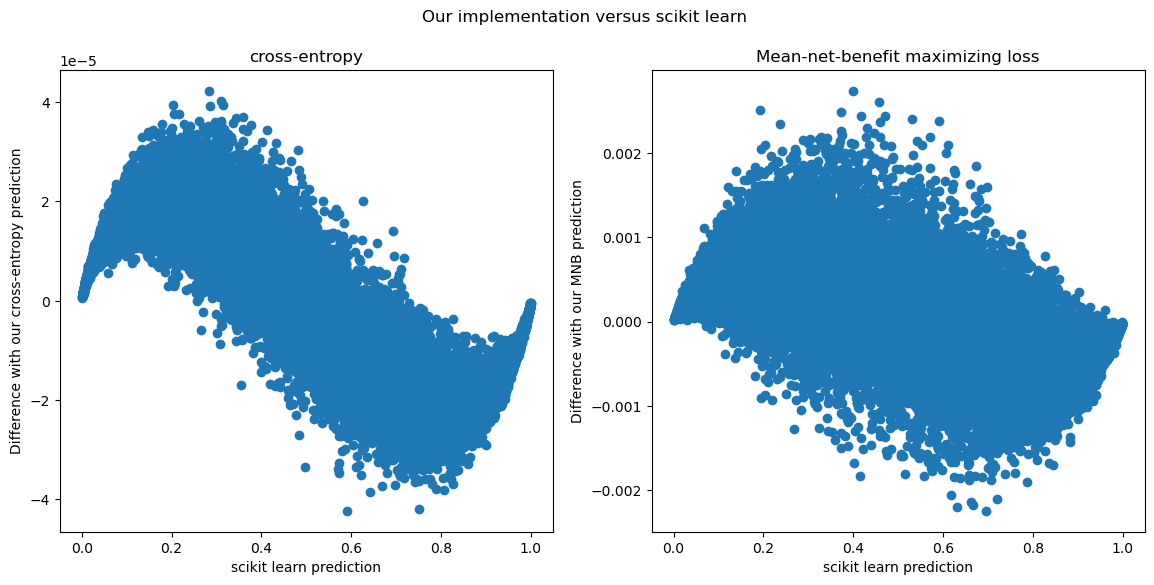

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(14, 6))
fig.suptitle('Our implementation versus scikit learn')
ax1.scatter(combined_predictions["sklearn"], combined_predictions["delta_skl_log"])
ax2.scatter(combined_predictions["sklearn"], combined_predictions["delta_skl_mnb"])

ax1.set_xlabel("scikit learn prediction")
ax1.set_ylabel("Difference with our cross-entropy prediction")
ax1.set_title("cross-entropy")

ax2.set_xlabel("scikit learn prediction")
ax2.set_ylabel("Difference with our MNB prediction")
ax2.set_title("Mean-net-benefit maximizing loss")

fig.show()

Compare parameters:

In [18]:

sklearn_params = logreg.coef_[0]
my_log_loss_params = my_log_loss_model['net'].linear.weight.detach().numpy()[0]
my_mnb_loss_params = my_mnb_loss_model['net'].linear.weight.detach().numpy()[0]

combined_params = pd.concat([
    pd.DataFrame(true_params, columns = ["True"]),
    pd.DataFrame(sklearn_params.transpose(), columns = ["sklearn"]),
    pd.DataFrame(my_log_loss_params.transpose(), columns = ["log"]),
    pd.DataFrame(my_mnb_loss_params.transpose(), columns = ["mnb"])
],
axis = 1)

combined_params

,True,sklearn,log,mnb
0,1.7,1.687298,1.687445,1.690792
1,0.8,0.799931,0.800029,0.801813
2,-0.4,-0.402955,-0.402968,-0.406665


In order to assess the comparison we take 300 bootstrap samples of the training set, and re-fit the models on each. We calculate both AUC and mean-net-benefit (MNB) on the held-out test set. 

In [19]:
# Set this variabe to decide whether to load the previously run picked version or recalculate
load_pickled_version = True  

if load_pickled_version:
    with open('../data/benchmark-01.pkl', 'rb') as f:
        [skl_boot, torch_boot_log, torch_boot_mnb] = pickle.load(f)
else:
    n_bootstraps = 300

    skl_boot = []
    torch_boot_log = []
    torch_boot_mnb = []

    for i in range(3):
        for boot in range(n_bootstraps):
            #Make a bootstrap sample
            #-------------------------#
            df_boot = df_train.sample(frac=1, replace=True)

            #scikit learn
            #-------------
            skl_boot.append(dcat.lr_skl_boot(logreg, df_boot, df_test, label = i))

            # torch - log-loss
            #-------
            torch_boot_log.append(dcat.lr_boot(df_boot, df_test, loss_fun="log", label = i))

            # torch - mnb-loss
            #-------
            torch_boot_mnb.append(dcat.lr_boot(df_boot, df_test, loss_fun="mnb", label = i))

    skl_boot = pd.concat(skl_boot, axis = 0).reset_index().drop("index", axis=1)
    torch_boot_log = pd.concat(torch_boot_log, axis = 0).reset_index().drop("index", axis=1)
    torch_boot_mnb = pd.concat(torch_boot_mnb, axis = 0).reset_index().drop("index", axis=1)


    with open('tmp0.pkl', 'wb') as f:
        pickle.dump([skl_boot, torch_boot_log, torch_boot_mnb], f)

For each of the three models we plot the bootstrap distributions of the AUC and mean-net-benefit and also the parameter values.

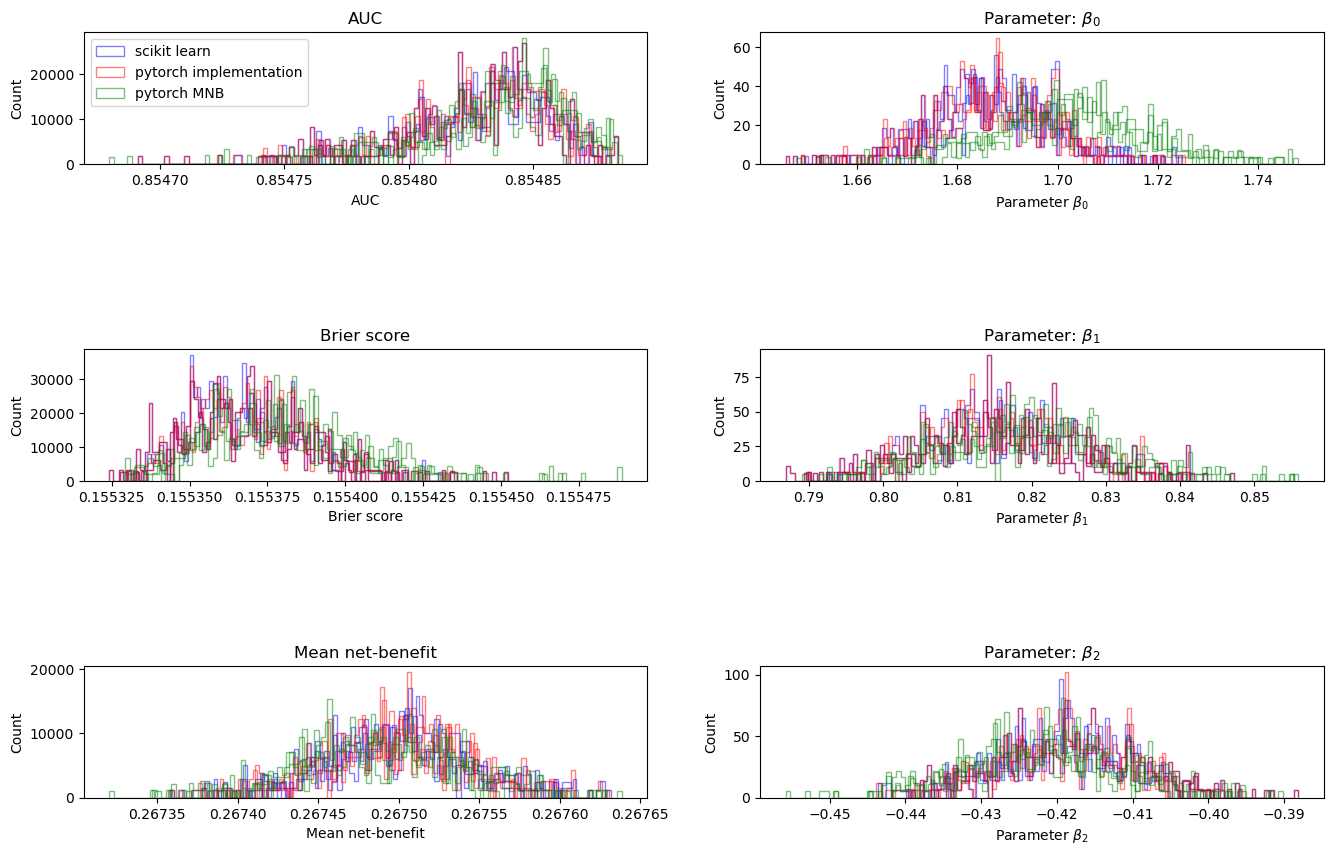

In [20]:
dcat.plot_bootstrap(skl_boot, torch_boot_log, torch_boot_mnb)

## Conclusion

We see that each of the three models gives very similar results when applied to a synthetic dataset to which a logistic regression model is well-specified.

We note that the mean-net-benefit maximizing loss function model results look identical to the standard cross-entropy logistic regression models in this case. The next example will highlight a situation in which there is a difference. 